In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import zeros, ones, arange, pi, sin, sqrt
import math
import control as control
from scipy.integrate import odeint
from scipy import signal
from asyncio.windows_events import NULL
from sklearn.metrics import r2_score

In [87]:
Ta = 0.01  # intervalo de amostragem
##planta
gain = -0.001334 
polo1 = -0.01624
Num = -gain
Den = [1,-polo1 ]
# Definindo dinamica da planta
def din_aeropend(y, t, input):
    x1 = y
    # Dinamica do pendulo
    x1p = (gain*input) + (polo1*x1)
    return x1p

In [88]:
## requisitos
ms = 0.09 # maximo sobresinal de 6 porcento 
tr = 350 # tempo de subida de 350 segundos 
eps = math.sqrt((math.log(ms)**2) / ((math.pi**2) + (math.log(ms)**2)))
print(f"eps: {eps}")
wn = (math.pi - math.acos(eps))/(tr *  math.sqrt( 1 -(eps**2)))
print(f"wn: {wn}")
s1 = complex(-eps * wn ,   wn *  math.sqrt( 1 -(eps**2)))
s2 = complex(-eps * wn ,  -wn *  math.sqrt( 1 -(eps**2)))
print(f"S1: {s1}")
print(f"S2: {s2}")

eps: 0.6083346775231739
wn: 0.00800882425524512
S1: (-0.004872045520654313+0.0063564485678777255j)
S2: (-0.004872045520654313-0.0063564485678777255j)


In [89]:
##controlador
teta1 = math.atan (-s1.imag/ (polo1 - s1.real))
teta2 = math.pi - math.atan (-s1.imag / s1.real)
print(f"teta1: {teta1*180/math.pi}, teta1: {teta2*180/math.pi}")
alfa = math.pi - (teta1 + teta2)
print(f"alfa: {alfa*180/math.pi}")
zeroC = s1.real - (s1.imag / math.tan(alfa))
print(f"zero controlador: {zeroC}")
G = - 0.01334/ (s1 +0.01624)
c = (zeroC+ s1)/s1
gainC = 1/abs(G*c)
print(f"ganho controlador {gainC}" )
Ccont = control.tf([gainC, -gainC*zeroC], [1,0])
print(f"C(S) = {Ccont}")


teta1: 29.21195630776733, teta1: 127.46918647097954
alfa: 23.318857221253133
zero controlador: -0.019618192781232655
ganho controlador 0.3090442581490969
C(S) = 
0.309 s + 0.006063
------------------
        s



In [90]:
Cd = control.c2d(Ccont, Ta, 'zoh')
print(f"C(z) = {Cd}")
ca = Cd.num[0][0][0]
cb = -Cd.num[0][0][1]

C(z) = 
0.309 z - 0.3084
----------------
     z - 1

dt = 0.1



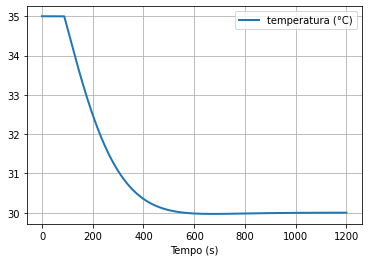

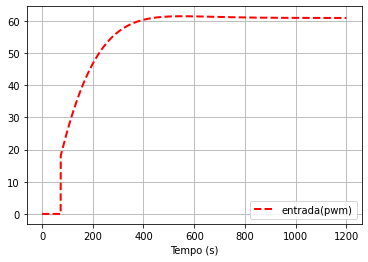

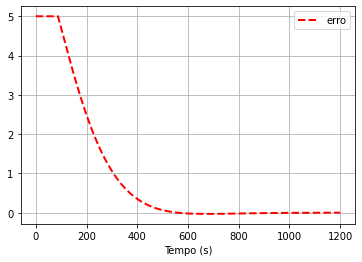

In [82]:
# Parametros de simulacao
Tsim = 1200  # tempo de simulacao
kend = int(Tsim/Ta)
Tdelay = 14
# ca = 0.0347
# cb = 0.02613

# Scopes
input = zeros(kend)  # rad/s
temp = zeros(kend)  # posicao angular
erro = zeros(kend)  # erro de rastreamento

temp_ref = zeros(kend)  # referencia p/ posicao angular

# Valores de equilibrio
temp_init = 35
input_init = 0


input_before = 0.0
# Loop
for k in range(kend-1):

    # Entrada da planta
    
    temp_ref[k] = -5
    erro[k] =  temp[k] - temp_ref[k]
        # Acao de controle (controlador PI+V)
    if(k-int(Tdelay/Ta)> 0):
        input[k] = (ca*erro[k]) - (cb*erro[k-1]) + input_before
        # parcela = (ka*erro[k]) - (A*erro[k-1]) 
        input_before = input[k]
    #saturação
    if(input[k]< 18):
        input[k] = 0
    if(input[k]> 85):
        input[k] = 85
    
    # Evoluindo a din. da planta
    x0 = [temp[k],]   # condicao inicial
    sol = odeint(din_aeropend, x0, [0.0, Ta], args=(input[k-int(Tdelay/Ta)] + input_init,))
    temp[k + 1] = sol[:, 0][-1]

# Plotando resultados
fig1 = plt.figure()
time = arange(0, Tsim, Ta)
plt.plot(time, (temp + temp_init), lw=2, label=r'temperatura (°C)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

fig2 = plt.figure()
plt.plot(arange(0, Tsim-Ta, Ta), input[0:-1] + input_init, 'r--', lw=2, label=r'entrada(pwm)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

fig3 = plt.figure()
plt.plot(arange(0, Tsim-Ta, Ta), erro[0:-1], 'r--', lw=2, label=r'erro')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

plt.show()